In [1]:
import PIL
import torch
import glob as gb
import numpy as np
from PIL import Image
import os
import random
import torch.nn as nn
import pandas as pd 

from numpy import dot
from numpy.linalg import norm
import matplotlib.pyplot as plt
import random

from facenet_pytorch import MTCNN, InceptionResnetV1
import torchvision.transforms as transforms

random.seed(1)
np.random.seed(1)

In [2]:
# Hyper parameters

def cos_sim(a,b):
    return 1 - dot(a, b)/(norm(a)*norm(b))

def euc_dis(a,b):
    return norm(a-b)

def l2_error(a,b):
    return sum((a-b)**2)

def load_image(path='', resize=True, size=160):
    '''
    VGGFace2 Data has mean = (131.0912, 103.8827, 91.4953)
    and std = (1,1,1) with no scaling
    '''
    img = Image.open(path)
    if resize:
        img = img.resize((size,size), resample=PIL.Image.BICUBIC)
    return img

In [3]:
resnet = InceptionResnetV1(pretrained='vggface2').eval()

In [5]:
def return_embedding(img_path):
    img_as_tensor = transforms.ToTensor()(load_image(img_path))
    img_emb = resnet(img_as_tensor.unsqueeze(0)).squeeze(0).detach().numpy()
    return img_emb

def return_batch_embedding(imgs_path):
    img_array = [transforms.ToTensor()(load_image(path)) for path in imgs_path]
    emb_array = [resnet(img.unsqueeze(0)).squeeze(0).detach().numpy() for img in img_array]
    return np.array(emb_array)

In [39]:
img_path = '/media/angelo/DATEN/Datasets/Dados_TCC_Joao/Material TCC/Classe3/Classe/'

gallery_path = gb.glob(img_path + 'faces_bd/*.png')
gallery_names = [os.path.splitext(name)[0] for name in os.listdir(img_path + 'faces_bd/')]

face_embeddings = return_batch_embedding(gallery_path)

In [ ]:
probe_path = img_path + 'probe/'
student_pool_list = gallery_names

real_embedding = return_embedding(img_path + 'gallery/00' + student_pool_list[0] + '_f.jpg')

guilty_student_path = gb.glob(probe_path + student_pool_list[0] + '/*.jpg')
sample_1_student = gb.glob(probe_path + student_pool_list[1] + '/*.jpg')
sample_2_student = gb.glob(probe_path + student_pool_list[2] + '/*.jpg')
sample_3_student = gb.glob(probe_path + student_pool_list[3] + '/*.jpg')

print('For student ' + student_pool_list[0])
print('Similarity with his own probe photos: ')

guilty_student_emb = return_batch_embedding(guilty_student_path)
similarities = [cos_sim(real_embedding, guilty_student_emb[i]) for i in range(5)]
print(similarities)

print('Similarity with probe photos of ' + student_pool_list[1])

guilty_student_emb = return_batch_embedding(sample_1_student)
similarities = [cos_sim(real_embedding, guilty_student_emb[i]) for i in range(5)]
print(similarities)

print('Similarity with probe photos of ' + student_pool_list[2])

guilty_student_emb = return_batch_embedding(sample_2_student)
similarities = [cos_sim(real_embedding, guilty_student_emb[i]) for i in range(5)]
print(similarities)

print('Similarity with probe photos of ' + student_pool_list[3])

guilty_student_emb = return_batch_embedding(sample_3_student)
similarities = [cos_sim(real_embedding, guilty_student_emb[i]) for i in range(5)]
print(similarities)

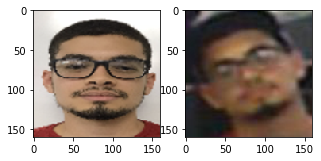

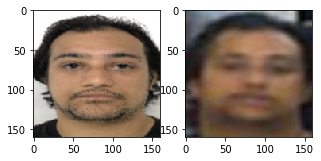

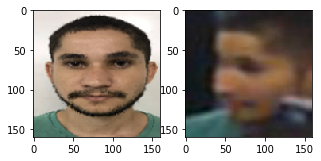

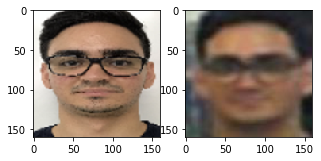

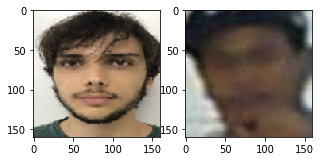

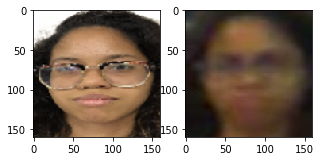

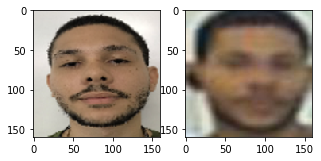

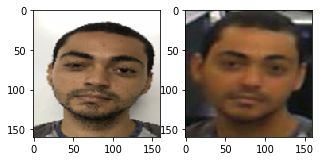

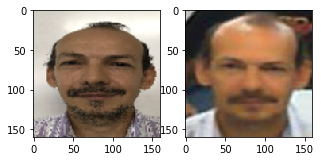

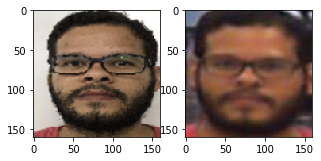

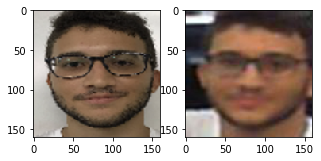

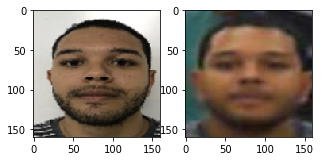

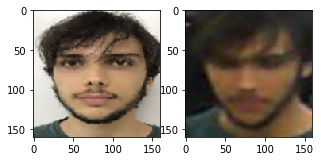

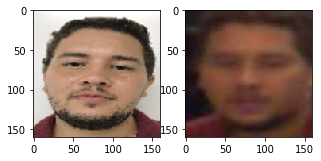

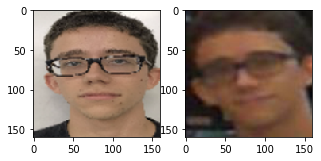

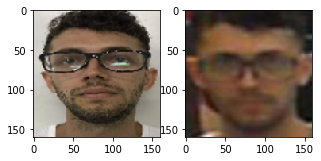

In [45]:
# Experimentation
probe_path = img_path + 'WebCam - 1.2MP/'
#class_folder = [folder for folder in os.listdir(probe_path) if os.path.isdir(os.path.join(probe_path, folder))] 

probe_path = probe_path + 'Classe_1/'
student_pool_list = os.listdir(probe_path)

for index, student in enumerate(student_pool_list):
    
    student_emb = return_embedding(probe_path + student)
    
    similarities = [cos_sim(student_emb, face_embeddings[i]) for i in range(len(face_embeddings))]
    
    least_dis = np.argmin(np.array(similarities))
    
    plt.figure(figsize=(5,5))
    plt.subplot(1,2,1)
    plt.imshow(load_image(gallery_path[least_dis]))
    plt.subplot(1,2,2)
    plt.imshow(load_image(probe_path + student))
    
    #print('Student {}/{}'.format(index+1,len(student_pool_list)))
    #print('For student ' + student)
    #print(pd.DataFrame(similarities))
    #print('------------------------------------------------')